In [1]:
!pip install pingouin


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
from matplotlib import ticker
from scipy.stats import ttest_ind, levene, mannwhitneyu,shapiro, \
    f_oneway, kruskal, chi2_contingency, fisher_exact
import numpy as np
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve
import pingouin as pg
from statsmodels.graphics.mosaicplot import mosaic

pd.set_option('display.max_columns', None)

In [3]:
dtp = pd.read_csv('DTP_DATA_2025_PROCESSED.csv')
dtp

,Unnamed: 0,REGION,DATE,COORD_L,COORD_W,road_name,road_category,n_VEHICLES,n_PARTICIPANTS,ID,n_DEATHS,n_INJURED,vehicle_failure,non_private_vehicle,russian_vehicle,white_vehicle,black_vehicle,colored_vehicle,drunk_driver,female_driver,escaped,no_seatbelt_injury,n_drunk,n_children,n_cyclists,n_pedestrians,vehicle_age_min,vehicle_age_max,vehicle_age_avg,n_class_a,n_class_b,n_class_c,n_class_d,n_class_e,n_class_s,n_front_drive,n_rear_drive,n_4wd,n_guilty,guilty_share,n_fatal_violations,guilty_exp_avg,exp_avg,road_rank_cat,road_defects_cat,traffic_changes_bin,traffic_changes_cat,road_surface_cat,TYPE_cat,out_of_town,street_rank_cat,weather_interpretable,weather_cat,adj_objects_interpretable,adj_objects_cat,cause_factors_cat,crossing_violation,impaired_driving,interference_violation,license_violation,maneuver_violation,other_violation,pedestrian_violation,sudden_appearance_violation,traffic_control_violation,transport_violation,vehicle_tech_violation,wrong_way,no_lighting,lighting_cat,site_objects_cat,severity,YEAR,MONTH,WEEKDAY,SEASON,is_WEEKEND,HOUR,is_NIGHT,is_PEAK_HOUR
0,6,1,31.01.2015,81.151944,53.740000,Романово - Завьялово - Баево - Камень-на-Оби,5.0,1,3,161242174,0,3,0,0,0,0,0,1,0,0,1,1,0,0,0,0,2003.0,2003.0,2003.0,0,1,0,0,0,0,0,0,0,1,1.0,4,17.0,17.0,3,5,0,2,7,7,1,0,nothing,5,no_obj,4,18,0,0,0,0,0,1,0,0,0,1,0,0,0,4,12,2,2015,1,5,1,1,9,0,1
1,8,1,30.01.2015,85.018056,51.684444,Куяган - Куяча - Тоурак,6.0,2,3,161105683,0,2,0,1,0,1,0,1,0,0,0,0,0,0,0,0,2002.0,2004.0,2003.0,1,0,0,0,0,0,0,0,0,1,0.5,1,7.0,10.0,3,5,0,2,1,7,1,0,nothing,5,no_obj,4,18,0,0,0,0,0,0,0,0,0,0,0,1,0,0,12,2,2015,1,4,1,0,14,0,0
2,12,1,30.01.2015,81.250000,53.818056,Барнаул - Камень-на-Оби - граница Новосибирско...,5.0,2,3,161763431,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,2005.0,2008.0,2006.5,0,1,0,0,0,0,0,0,0,1,0.5,1,2.0,15.5,3,5,0,2,7,7,1,0,nothing,5,no_obj,4,18,0,0,0,0,0,0,0,0,0,0,0,1,0,0,12,1,2015,1,4,1,0,17,0,1
3,39,1,24.01.2015,51.000000,84.000000,Быканов Мост - Солоновка - Солонешное - границ...,7.0,1,2,160331994,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,2000.0,2000.0,2000.0,0,1,0,0,0,0,0,0,0,1,1.0,2,26.0,26.0,3,5,0,2,1,7,1,0,nothing,5,no_obj,4,18,0,1,0,0,0,0,0,0,1,0,0,0,1,2,12,1,2015,1,5,1,1,19,0,0
4,42,1,23.01.2015,84.000000,53.000000,Быканов Мост - Солоновка - Солонешное - границ...,7.0,1,2,160213415,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2003.0,2003.0,2003.0,0,1,0,0,0,0,0,0,0,1,1.0,1,18.0,18.0,3,5,0,2,1,7,1,0,LOW_VISIBILITY,3,no_obj,4,18,0,0,0,0,0,0,0,0,0,0,0,1,1,2,12,3,2015,1,4,1,0,21,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473183,1475642,10011,18.12.2022,55.731164,67.417464,"г. Нарьян-Мар - г. Усинск, участок г. Нарьян-М...",5.0,1,1,222679998,1,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,2020.0,2020.0,2020.0,0,0,0,0,0,0,0,0,1,1,1.0,1,31.0,31.0,3,5,0,2,1,7,1,4,nothing,5,no_obj,4,18,0,0,0,0,0,0,0,0,0,0,0,1,1,2,3,3,2022,12,6,1,1,15,0,0
473184,1475665,10011,16.06.2024,54.095821,67.629532,"г. Нарьян-Мар - г. Усинск, участок г. Нарьян-М...",6.0,1,2,223892751,0,2,0,0,0,0,1,0,1,0,0,1,2,0,0,0,2023.0,2023.0,2023.0,0,0,0,1,0,0,0,0,1,1,1.0,4,8.0,8.0,3,5,0,2,7,7,1,0,nothing,5,no_obj,4,18,0,0,0,0,0,0,0,0,1,1,0,0,0,0,12,1,2024,6,6,3,1,9,0,1
473185,1475669,10011,04.07.2024,53.607541,67.836463,Подъездная автомобильная дорога к п. Красное,1.0,1,1,223948754,0,1,0,0,0,0,0,1,1,1,0,1,1,0,0,0,2011.0,2011.0,2011.0,0,0,0,0,0,0,0,0,0,1,1.0,1,24.0,24.0,3,13,0,2,2,7,1,4,LOW_VISIBILITY,3,LIVING_OBJ,1,18,0,0,0,0,0,0,0,0,1,0,0,0,0,0,6,2,2024,7,3,3,0,9,0,1
473186,1475671,10011,25.08.2024,53.612724,67.837285,Подъездная автомобильная дорога к п. Красное,4.0,1,1,224161731,0,1,0,0,0,0,0,1,1,0,0,1,1,0,0,0,2024.0,2024.0,2024.0,0,0,0,0,0,0,0,0,0,1,1.0,4,95.0,95.0,3,5,0,2,7,4,1,4,nothing,5,SOCIAL_OBJ,3,18,0,0,0,1,0,1,0,0,1,1,0,0,0,0,12,1,2024,

In [4]:
dtp = dtp.drop('Unnamed: 0', axis=1)

In [5]:
dtp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 473188 entries, 0 to 473187
Data columns (total 79 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   REGION                       473188 non-null  int64  
 1   DATE                         473188 non-null  object 
 2   COORD_L                      473188 non-null  float64
 3   COORD_W                      473188 non-null  float64
 4   road_name                    473188 non-null  object 
 5   road_category                473188 non-null  float64
 6   n_VEHICLES                   473188 non-null  int64  
 7   n_PARTICIPANTS               473188 non-null  int64  
 8   ID                           473188 non-null  int64  
 9   n_DEATHS                     473188 non-null  int64  
 10  n_INJURED                    473188 non-null  int64  
 11  vehicle_failure              473188 non-null  int64  
 12  non_private_vehicle          473188 non-null  int64  
 13 

In [6]:
dtp.describe()

,REGION,COORD_L,COORD_W,road_category,n_VEHICLES,n_PARTICIPANTS,ID,n_DEATHS,n_INJURED,vehicle_failure,non_private_vehicle,russian_vehicle,white_vehicle,black_vehicle,colored_vehicle,drunk_driver,female_driver,escaped,no_seatbelt_injury,n_drunk,n_children,n_cyclists,n_pedestrians,vehicle_age_min,vehicle_age_max,vehicle_age_avg,n_class_a,n_class_b,n_class_c,n_class_d,n_class_e,n_class_s,n_front_drive,n_rear_drive,n_4wd,n_guilty,guilty_share,n_fatal_violations,guilty_exp_avg,exp_avg,road_rank_cat,road_defects_cat,traffic_changes_bin,traffic_changes_cat,road_surface_cat,TYPE_cat,out_of_town,street_rank_cat,weather_cat,adj_objects_cat,cause_factors_cat,crossing_violation,impaired_driving,interference_violation,license_violation,maneuver_violation,other_violation,pedestrian_violation,sudden_appearance_violation,traffic_control_violation,transport_violation,vehicle_tech_violation,wrong_way,no_lighting,lighting_cat,site_objects_cat,severity,YEAR,MONTH,WEEKDAY,SEASON,is_WEEKEND,HOUR,is_NIGHT,is_PEAK_HOUR
count,473188.000000,473188.000000,473188.000000,473188.000000,473188.000000,473188.000000,4.731880e+05,473188.000000,473188.000000,473188.000000,473188.000000,473188.0,473188.000000,473188.000000,473188.00000,473188.000000,473188.000000,473188.000000,473188.000000,473188.000000,473188.000000,473188.000000,473188.0,473188.000000,473188.000000,473188.000000,473188.000000,473188.000000,473188.000000,473188.000000,473188.000000,473188.000000,473188.000000,473188.000000,473188.000000,473188.000000,473188.000000,473188.000000,473188.000000,473188.000000,473188.000000,473188.00000,473188.000000,473188.000000,473188.000000,473188.000000,473188.000000,473188.000000,473188.000000,473188.000000,473188.000000,473188.000000,473188.000000,473188.000000,473188.000000,473188.000000,473188.000000,473188.000000,473188.000000,473188.000000,473188.000000,473188.000000,473188.000000,473188.000000,473188.000000,473188.000000,473188.000000,473188.000000,473188.000000,473188.000000,473188.000000,473188.000000,473188.000000,473188.000000,473188.000000
mean,1018.523274,54.059296,52.629785,4.509360,1.760736,2.609893,2.102570e+08,0.205553,1.432790,0.078206,0.105956,0.0,0.352160,0.208896,0.78066,0.327333,0.192232,0.052721,0.407954,0.627630,0.029703,0.018232,0.0,2004.412041,2009.837438,2007.168535,0.050766,0.629329,0.254516,0.111590,0.018591,0.002487,0.746483,0.272285,0.161805,1.038729,0.702577,2.008629,22.848080,21.765475,3.211675,5.76950,0.295686,1.697765,5.404807,6.240756,0.930131,1.298731,4.060403,3.641003,17.651113,0.025812,0.171365,0.010816,0.110863,0.321902,0.405976,0.016226,0.008570,0.260958,0.104269,0.042596,0.345751,0.233326,0.903434,10.593551,1.720101,2019.228015,6.998960,3.192203,2.642573,0.331439,13.275660,0.182213,0.324685
std,8253.798282,27.106836,7.576121,1.607698,0.747296,1.304635,1.651806e+07,0.529305,1.019438,0.268495,0.307781,0.0,0.477644,0.406520,0.41380,0.469240,0.394055,0.223476,0.491455,1.161102,0.209899,0.135671,0.0,24.620541,8.611824,14.170945,0.257251,0.745079,0.536908,0.370067,0.141509,0.050486,0.772056,0.524263,0.404543,0.202388,0.320690,1.225376,27.008183,23.108296,0.815603,2.84113,0.456351,0.473274,2.332701,1.562857,0.254926,1.924206,1.191703,2.084035,2.302127,0.158575,0.376828,0.103436,0.313963,0.467206,0.491080,0.126344,0.092174,0.439157,0.305610,0.201945,0.475613,0.422948,1.243041,2.635784,0.727649,2.914456,3.287765,2.020294,1.102930,0.470731,5.985729,0.386020,0.468257
min,1.000000,-173.113332,0.000000,1.000000,1.000000,1.000000,1.017752e+08,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.250000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000

n_pedestrians у нас полностью пустое

In [7]:
dtp.duplicated().value_counts()

False    473188
Name: count, dtype: int64

In [8]:
dtp['ID'].duplicated().value_counts()

ID
False    473188
Name: count, dtype: int64

In [9]:
dtp.isna().any().value_counts()

False    79
Name: count, dtype: int64

Дубликатов и пропусков нет

In [10]:
dtp['vehicle_age_min']

0         2003.0
1         2002.0
2         2005.0
3         2000.0
4         2003.0
           ...  
473183    2020.0
473184    2023.0
473185    2011.0
473186    2024.0
473187    1991.0
Name: vehicle_age_min, Length: 473188, dtype: float64

In [11]:
dtp['vehicle_age_min'] = dtp['vehicle_age_min'].astype('int')

In [12]:
dtp['max_car_age'] = dtp['YEAR'] - dtp['vehicle_age_min']

max_car_age обозначает максимальный возраст в годах ТС в ДТП

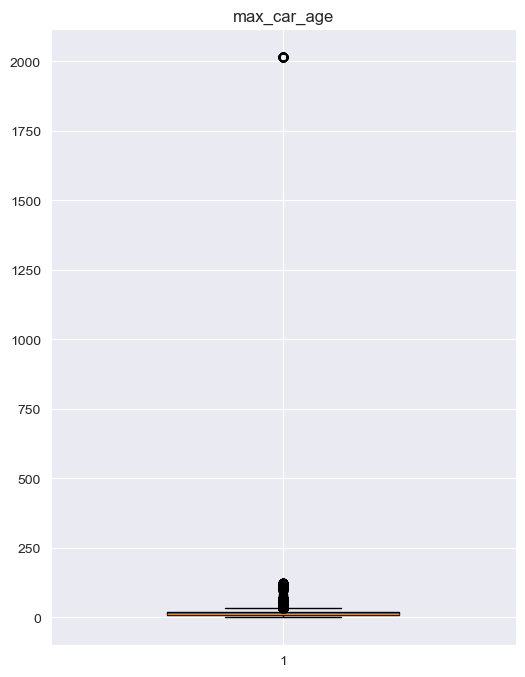

In [13]:
x = dtp['max_car_age']

fig, ax = plt.subplots(figsize=(6, 8))

box = ax.boxplot(
    x,
    widths=0.5,
    patch_artist=True
)

box_patch = box['boxes'][0]
path = box_patch.get_path()
vertices = path.vertices

box_x_left = vertices[:, 0].min()
box_x_right = vertices[:, 0].max()

ax.set_title("max_car_age")
plt.show()

In [14]:
dtp[dtp['max_car_age'] > 500]

,REGION,DATE,COORD_L,COORD_W,road_name,road_category,n_VEHICLES,n_PARTICIPANTS,ID,n_DEATHS,n_INJURED,vehicle_failure,non_private_vehicle,russian_vehicle,white_vehicle,black_vehicle,colored_vehicle,drunk_driver,female_driver,escaped,no_seatbelt_injury,n_drunk,n_children,n_cyclists,n_pedestrians,vehicle_age_min,vehicle_age_max,vehicle_age_avg,n_class_a,n_class_b,n_class_c,n_class_d,n_class_e,n_class_s,n_front_drive,n_rear_drive,n_4wd,n_guilty,guilty_share,n_fatal_violations,guilty_exp_avg,exp_avg,road_rank_cat,road_defects_cat,traffic_changes_bin,traffic_changes_cat,road_surface_cat,TYPE_cat,out_of_town,street_rank_cat,weather_interpretable,weather_cat,adj_objects_interpretable,adj_objects_cat,cause_factors_cat,crossing_violation,impaired_driving,interference_violation,license_violation,maneuver_violation,other_violation,pedestrian_violation,sudden_appearance_violation,traffic_control_violation,transport_violation,vehicle_tech_violation,wrong_way,no_lighting,lighting_cat,site_objects_cat,severity,YEAR,MONTH,WEEKDAY,SEASON,is_WEEKEND,HOUR,is_NIGHT,is_PEAK_HOUR,max_car_age
488,1,18.08.2015,81.135833,51.302778,Змеиногорск - Рубцовск - Волчиха - Михайловско...,5.0,2,2,176168626,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,1998.0,999.5,0,0,0,1,0,0,0,0,0,1,0.5,2,0.0,0.5,3,5,0,2,7,1,1,4,nothing,5,no_obj,4,18,0,1,0,0,0,0,0,0,0,0,0,1,1,2,12,1,2015,8,1,3,0,22,1,0,2014
9592,3,06.10.2015,39.134740,45.160070,СТ-ЦА ДИНСКАЯ - СТ-ЦА ПЛАСТУНОВСКАЯ,4.0,2,2,178895771,0,1,0,1,0,1,0,1,0,0,0,1,0,0,1,0,1,2010.0,1005.5,0,0,0,0,0,0,0,0,0,1,0.5,1,18.0,9.0,3,5,0,2,7,1,1,0,nothing,5,no_obj,4,18,0,0,0,0,1,0,0,0,0,0,0,0,0,0,12,2,2015,10,1,4,0,13,0,0,2014
35758,4,13.06.2015,89.573056,56.235556,Обход Боготола,6.0,2,2,171953898,0,1,0,0,0,0,1,1,0,0,0,1,0,0,1,0,1,1993.0,997.0,0,0,0,0,0,0,0,0,0,2,1.0,1,8.0,8.0,1,5,0,2,7,1,1,0,nothing,5,no_obj,4,18,0,0,0,0,0,1,0,0,0,0,0,0,0,0,12,2,2015,6,5,3,1,13,0,0,2014
46692,5,29.07.2015,133.373889,44.170833,Осиновка - Рудная Пристань,3.0,2,2,175086322,1,0,0,0,0,0,0,1,1,0,0,1,1,0,1,0,1,1993.0,997.0,0,0,0,0,0,0,0,0,0,1,0.5,2,0.0,6.5,3,1,0,2,7,1,1,0,ABOVE_30_DGR,0,ROAD_INFRSTRCT,0,18,0,0,0,0,0,1,0,0,1,0,0,0,0,0,6,3,2015,7,2,3,0,12,0,0,2014
46744,5,23.07.2015,131.983056,43.988333,Михайловка – Дальнее,4.0,2,2,174454530,1,0,0,0,0,1,0,1,1,0,0,1,1,0,1,0,1,2002.0,1001.5,0,1,0,0,0,0,0,0,0,1,0.5,1,0.0,2.5,3,5,0,2,7,1,1,0,nothing,5,no_obj,4,18,0,0,0,0,0,1,0,0,0,0,0,0,0,0,12,3,2015,7,3,3,0,13,0,0,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415449,84,15.07.2015,85.846667,51.956944,Р-256 Чуйский тракт Новосибирск - Барнаул - Го...,3.0,2,2,174093303,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,1998.0,999.5,0,0,0,1,0,0,0,0,0,2,1.0,1,2.0,2.0,4,5,0,2,7,1,1,0,nothing,5,no_obj,4,18,0,0,0,0,0,1,0,0,0,0,0,0,1,2,12,2,2015,7,2,3,0,22,1,0,2014
419723,86,24.08.2015,30.200278,61.524167,А-121 Сортавала Санкт-Петербург - Сортавала - ...,5.0,2,2,178304614,0,1,0,0,0,0,1,1,0,0,0,1,0,0,1,0,1,1978.0,989.5,0,1,0,0,0,0,0,0,0,1,0.5,1,24.0,12.0,4,5,0,2,7,1,0,3,LOW_VISIBILITY,3,SOCIAL_OBJ,8,18,0,0,0,0,1,0,0,0,0,0,0,0,0,0,11,1,2015,8,0,3,0,18,0,1,2014
422793,87,14.07.2015,52.000000,49.000000,Вогваздино - Яренск от а/д Сыктывкар - Ухта,5.0,2,2,174103610,0,1,1,1,0,0,0,1,1,0,0,1,1,0,1,0,1,1995.0,998.0,0,0,0,0,0,0,0,0,0,1,0.5,3,0.0,8.0,3,14,1,1,7,1,1,0,LOW_VISIBILITY,3,ROAD_INFRSTRCT,0,18,0,0,0,0,1,1,0,0,0,0,1,0,0,0,6,2,2015,7,1,3,0,16,0,1,2014
438695,92,21.09.2015,48.828056,54.920000,Объездная автодорога г.Тетюши,8.0,2,2,177566939,0,1,0,0,0,0,0,1,1,0,0,1,1,0,1,0,1,2012.0,1006.5,0,1,0,0,0,0,0,0,0,1,0.5,1,0.0,14.5,2,14,0,2,7,1,0,1,nothing,5,no_obj,4,18,0,0,0,0,0,1,0,0,0,0,0,0,0,0,12,2,2015,9,0,4,0,10,0,0,2014


In [15]:
dtp = dtp.drop(dtp.loc[dtp['max_car_age'] > 500].index)

Убрали выбросы с 2000 лет

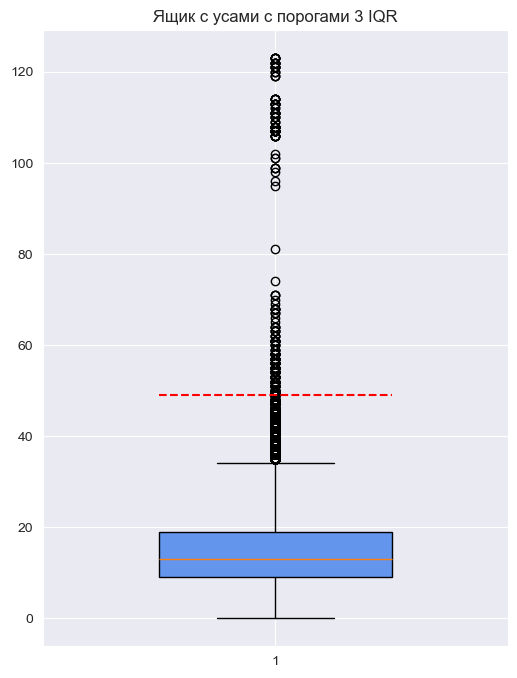

In [16]:
x = dtp['max_car_age']

Q1 = x.quantile(0.25)
Q3 = x.quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 3 * IQR
upper = Q3 + 3 * IQR

fig, ax = plt.subplots(figsize=(6, 8))

box = ax.boxplot(
    x,
    widths=0.5,
    patch_artist=True
)

box_color = (100/255, 149/255, 237/255)
box_patch = box['boxes'][0]
box_patch.set_facecolor(box_color)
box_patch.set_edgecolor('black')

path = box_patch.get_path()
vertices = path.vertices
box_x_left = vertices[:, 0].min()
box_x_right = vertices[:, 0].max()

ax.hlines(upper, box_x_left, box_x_right,
          colors='red', linestyles='--')

ax.set_title("Ящик с усами с порогами 3 IQR")
plt.show()


In [17]:
dtp_clean = dtp[(dtp['max_car_age'] >= lower) & (dtp['max_car_age'] <= upper)]
len(dtp) - len(dtp_clean)

426

In [18]:
dtp_clean

,REGION,DATE,COORD_L,COORD_W,road_name,road_category,n_VEHICLES,n_PARTICIPANTS,ID,n_DEATHS,n_INJURED,vehicle_failure,non_private_vehicle,russian_vehicle,white_vehicle,black_vehicle,colored_vehicle,drunk_driver,female_driver,escaped,no_seatbelt_injury,n_drunk,n_children,n_cyclists,n_pedestrians,vehicle_age_min,vehicle_age_max,vehicle_age_avg,n_class_a,n_class_b,n_class_c,n_class_d,n_class_e,n_class_s,n_front_drive,n_rear_drive,n_4wd,n_guilty,guilty_share,n_fatal_violations,guilty_exp_avg,exp_avg,road_rank_cat,road_defects_cat,traffic_changes_bin,traffic_changes_cat,road_surface_cat,TYPE_cat,out_of_town,street_rank_cat,weather_interpretable,weather_cat,adj_objects_interpretable,adj_objects_cat,cause_factors_cat,crossing_violation,impaired_driving,interference_violation,license_violation,maneuver_violation,other_violation,pedestrian_violation,sudden_appearance_violation,traffic_control_violation,transport_violation,vehicle_tech_violation,wrong_way,no_lighting,lighting_cat,site_objects_cat,severity,YEAR,MONTH,WEEKDAY,SEASON,is_WEEKEND,HOUR,is_NIGHT,is_PEAK_HOUR,max_car_age
0,1,31.01.2015,81.151944,53.740000,Романово - Завьялово - Баево - Камень-на-Оби,5.0,1,3,161242174,0,3,0,0,0,0,0,1,0,0,1,1,0,0,0,0,2003,2003.0,2003.0,0,1,0,0,0,0,0,0,0,1,1.0,4,17.0,17.0,3,5,0,2,7,7,1,0,nothing,5,no_obj,4,18,0,0,0,0,0,1,0,0,0,1,0,0,0,4,12,2,2015,1,5,1,1,9,0,1,12
1,1,30.01.2015,85.018056,51.684444,Куяган - Куяча - Тоурак,6.0,2,3,161105683,0,2,0,1,0,1,0,1,0,0,0,0,0,0,0,0,2002,2004.0,2003.0,1,0,0,0,0,0,0,0,0,1,0.5,1,7.0,10.0,3,5,0,2,1,7,1,0,nothing,5,no_obj,4,18,0,0,0,0,0,0,0,0,0,0,0,1,0,0,12,2,2015,1,4,1,0,14,0,0,13
2,1,30.01.2015,81.250000,53.818056,Барнаул - Камень-на-Оби - граница Новосибирско...,5.0,2,3,161763431,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,2005,2008.0,2006.5,0,1,0,0,0,0,0,0,0,1,0.5,1,2.0,15.5,3,5,0,2,7,7,1,0,nothing,5,no_obj,4,18,0,0,0,0,0,0,0,0,0,0,0,1,0,0,12,1,2015,1,4,1,0,17,0,1,10
3,1,24.01.2015,51.000000,84.000000,Быканов Мост - Солоновка - Солонешное - границ...,7.0,1,2,160331994,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,2000,2000.0,2000.0,0,1,0,0,0,0,0,0,0,1,1.0,2,26.0,26.0,3,5,0,2,1,7,1,0,nothing,5,no_obj,4,18,0,1,0,0,0,0,0,0,1,0,0,0,1,2,12,1,2015,1,5,1,1,19,0,0,15
4,1,23.01.2015,84.000000,53.000000,Быканов Мост - Солоновка - Солонешное - границ...,7.0,1,2,160213415,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2003,2003.0,2003.0,0,1,0,0,0,0,0,0,0,1,1.0,1,18.0,18.0,3,5,0,2,1,7,1,0,LOW_VISIBILITY,3,no_obj,4,18,0,0,0,0,0,0,0,0,0,0,0,1,1,2,12,3,2015,1,4,1,0,21,0,0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473183,10011,18.12.2022,55.731164,67.417464,"г. Нарьян-Мар - г. Усинск, участок г. Нарьян-М...",5.0,1,1,222679998,1,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,2020,2020.0,2020.0,0,0,0,0,0,0,0,0,1,1,1.0,1,31.0,31.0,3,5,0,2,1,7,1,4,nothing,5,no_obj,4,18,0,0,0,0,0,0,0,0,0,0,0,1,1,2,3,3,2022,12,6,1,1,15,0,0,2
473184,10011,16.06.2024,54.095821,67.629532,"г. Нарьян-Мар - г. Усинск, участок г. Нарьян-М...",6.0,1,2,223892751,0,2,0,0,0,0,1,0,1,0,0,1,2,0,0,0,2023,2023.0,2023.0,0,0,0,1,0,0,0,0,1,1,1.0,4,8.0,8.0,3,5,0,2,7,7,1,0,nothing,5,no_obj,4,18,0,0,0,0,0,0,0,0,1,1,0,0,0,0,12,1,2024,6,6,3,1,9,0,1,1
473185,10011,04.07.2024,53.607541,67.836463,Подъездная автомобильная дорога к п. Красное,1.0,1,1,223948754,0,1,0,0,0,0,0,1,1,1,0,1,1,0,0,0,2011,2011.0,2011.0,0,0,0,0,0,0,0,0,0,1,1.0,1,24.0,24.0,3,13,0,2,2,7,1,4,LOW_VISIBILITY,3,LIVING_OBJ,1,18,0,0,0,0,0,0,0,0,1,0,0,0,0,0,6,2,2024,7,3,3,0,9,0,1,13
473186,10011,25.08.2024,53.612724,67.837285,Подъездная автомобильная дорога к п. Красное,4.0,1,1,224161731,0,1,0,0,0,0,0,1,1,0,0,1,1,0,0,0,2024,2024.0,2024.0,0,0,0,0,0,0,0,0,0,1,1.0,4,95.0,95.0,3,5,0,2,7,4,1,4,nothing,5,SOCIAL_OBJ,3,18,0,0,0,1,0,1,0,0,1,1,0,0,0,0,12,1,2024,8,6,3,1,14,0,0,0


Убрали выбросы вне 3 межквартильного размаха

In [19]:
df = dtp_clean.copy()
df["TYPE_cat"] = df["TYPE_cat"].replace({0: "Другое", 1: "Наезд на велосипедиста", 2: "Наезд на животное", 3: "Наезд на пешехода", 4: "Наезд на препятствие", 5: "Наезд на человека", 6: "Прочее", 7: "Столкновение"})
df["TYPE_cat"].describe()

count           472699
unique               8
top       Столкновение
freq            374028
Name: TYPE_cat, dtype: object

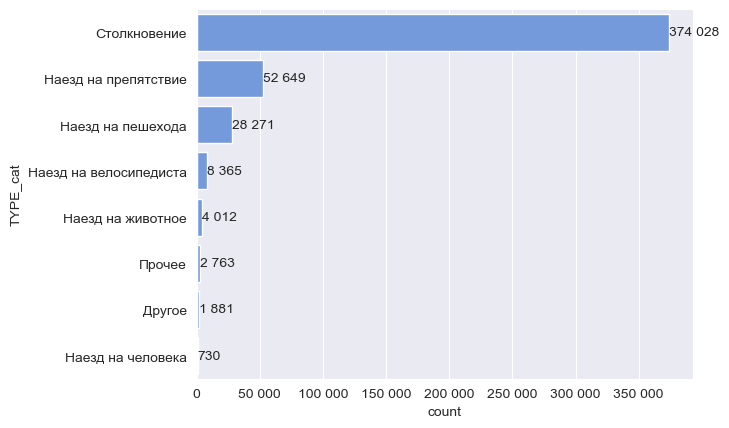

In [20]:
ax = sns.countplot(data=df, y="TYPE_cat", color="#6495ed", order=df["TYPE_cat"].value_counts(ascending=False).index)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:,.0f}'.replace(',', ' ')))
plt.bar_label(ax.containers[0], labels=[f'{x:,.0f}'.replace(',', ' ') for x in ax.containers[0].datavalues], label_type="edge")
plt.show()

In [21]:
new_dtp = dtp.copy()
new_dtp['is_car_type'] = new_dtp['TYPE_cat'].astype('str')
new_dtp['is_car_type'] = new_dtp['is_car_type'].apply(lambda x: True if (x == '4') | (x == '7') else False).astype('int')

In [22]:
dtp_clean['n_VEHICLES'].value_counts()

n_VEHICLES
2    216931
1    190344
3     53655
4     11769
Name: count, dtype: int64

In [23]:
class_cols = [
    'n_class_a',
    'n_class_b',
    'n_class_c',
    'n_class_d',
    'n_class_e',
    'n_class_s'
]

dtp_clean['all_auto'] = (dtp_clean[class_cols].sum(axis=1) == dtp_clean['n_VEHICLES']).astype('int')

/var/folders/08/s_xm1xcj58gcvj2xw408cmj80000gn/T/ipykernel_49129/352267587.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtp_clean['all_auto'] = (dtp_clean[class_cols].sum(axis=1) == dtp_clean['n_VEHICLES']).astype('int')


all_auto показывает все ли машины у нас среди ТС в ДТП

In [24]:
dtp_clean['all_auto']

0         1
1         0
2         0
3         1
4         1
         ..
473183    0
473184    1
473185    0
473186    0
473187    0
Name: all_auto, Length: 472699, dtype: int64

In [25]:
dtp_clean['TYPE_cat'].value_counts()

TYPE_cat
7    374028
4     52649
3     28271
1      8365
2      4012
6      2763
0      1881
5       730
Name: count, dtype: int64

In [26]:
df = dtp_clean.copy()
df["TYPE_cat"] = df["TYPE_cat"].replace({0: "Другое", 1: "Наезд на велосипедиста", 2: "Наезд на животное", 3: "Наезд на пешехода", 4: "Наезд на препятствие", 5: "Наезд на человека", 6: "Прочее", 7: "Столкновение"})
df["TYPE_cat"].describe()

count           472699
unique               8
top       Столкновение
freq            374028
Name: TYPE_cat, dtype: object

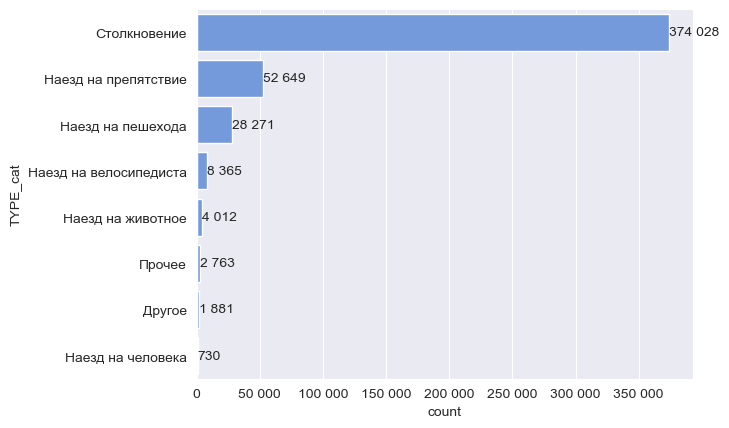

In [27]:
ax = sns.countplot(data=df, y="TYPE_cat", color="#6495ed", order=df["TYPE_cat"].value_counts(ascending=False).index)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:,.0f}'.replace(',', ' ')))
plt.bar_label(ax.containers[0], labels=[f'{x:,.0f}'.replace(',', ' ') for x in ax.containers[0].datavalues], label_type="edge")
plt.show()

Расшифровка TYPE_cat с подготовленного ноутбука getting_started_with_the_data:

'Другое', - 0

 'Наезд на велосипедиста', - 1

 'Наезд на животное', - 2

 'Наезд на пешехода', - 3

 'Наезд на препятствие', - 4

 'Наезд на человека', - 5

 'Прочее', - 6

 'Столкновение' - 7

In [28]:
dtp_clean[(dtp_clean['TYPE_cat'] == 7) | (dtp_clean['TYPE_cat'] == 4)]

,REGION,DATE,COORD_L,COORD_W,road_name,road_category,n_VEHICLES,n_PARTICIPANTS,ID,n_DEATHS,n_INJURED,vehicle_failure,non_private_vehicle,russian_vehicle,white_vehicle,black_vehicle,colored_vehicle,drunk_driver,female_driver,escaped,no_seatbelt_injury,n_drunk,n_children,n_cyclists,n_pedestrians,vehicle_age_min,vehicle_age_max,vehicle_age_avg,n_class_a,n_class_b,n_class_c,n_class_d,n_class_e,n_class_s,n_front_drive,n_rear_drive,n_4wd,n_guilty,guilty_share,n_fatal_violations,guilty_exp_avg,exp_avg,road_rank_cat,road_defects_cat,traffic_changes_bin,traffic_changes_cat,road_surface_cat,TYPE_cat,out_of_town,street_rank_cat,weather_interpretable,weather_cat,adj_objects_interpretable,adj_objects_cat,cause_factors_cat,crossing_violation,impaired_driving,interference_violation,license_violation,maneuver_violation,other_violation,pedestrian_violation,sudden_appearance_violation,traffic_control_violation,transport_violation,vehicle_tech_violation,wrong_way,no_lighting,lighting_cat,site_objects_cat,severity,YEAR,MONTH,WEEKDAY,SEASON,is_WEEKEND,HOUR,is_NIGHT,is_PEAK_HOUR,max_car_age,all_auto
0,1,31.01.2015,81.151944,53.740000,Романово - Завьялово - Баево - Камень-на-Оби,5.0,1,3,161242174,0,3,0,0,0,0,0,1,0,0,1,1,0,0,0,0,2003,2003.0,2003.0,0,1,0,0,0,0,0,0,0,1,1.0,4,17.0,17.0,3,5,0,2,7,7,1,0,nothing,5,no_obj,4,18,0,0,0,0,0,1,0,0,0,1,0,0,0,4,12,2,2015,1,5,1,1,9,0,1,12,1
1,1,30.01.2015,85.018056,51.684444,Куяган - Куяча - Тоурак,6.0,2,3,161105683,0,2,0,1,0,1,0,1,0,0,0,0,0,0,0,0,2002,2004.0,2003.0,1,0,0,0,0,0,0,0,0,1,0.5,1,7.0,10.0,3,5,0,2,1,7,1,0,nothing,5,no_obj,4,18,0,0,0,0,0,0,0,0,0,0,0,1,0,0,12,2,2015,1,4,1,0,14,0,0,13,0
2,1,30.01.2015,81.250000,53.818056,Барнаул - Камень-на-Оби - граница Новосибирско...,5.0,2,3,161763431,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,2005,2008.0,2006.5,0,1,0,0,0,0,0,0,0,1,0.5,1,2.0,15.5,3,5,0,2,7,7,1,0,nothing,5,no_obj,4,18,0,0,0,0,0,0,0,0,0,0,0,1,0,0,12,1,2015,1,4,1,0,17,0,1,10,0
3,1,24.01.2015,51.000000,84.000000,Быканов Мост - Солоновка - Солонешное - границ...,7.0,1,2,160331994,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,2000,2000.0,2000.0,0,1,0,0,0,0,0,0,0,1,1.0,2,26.0,26.0,3,5,0,2,1,7,1,0,nothing,5,no_obj,4,18,0,1,0,0,0,0,0,0,1,0,0,0,1,2,12,1,2015,1,5,1,1,19,0,0,15,1
4,1,23.01.2015,84.000000,53.000000,Быканов Мост - Солоновка - Солонешное - границ...,7.0,1,2,160213415,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2003,2003.0,2003.0,0,1,0,0,0,0,0,0,0,1,1.0,1,18.0,18.0,3,5,0,2,1,7,1,0,LOW_VISIBILITY,3,no_obj,4,18,0,0,0,0,0,0,0,0,0,0,0,1,1,2,12,3,2015,1,4,1,0,21,0,0,12,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473183,10011,18.12.2022,55.731164,67.417464,"г. Нарьян-Мар - г. Усинск, участок г. Нарьян-М...",5.0,1,1,222679998,1,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,2020,2020.0,2020.0,0,0,0,0,0,0,0,0,1,1,1.0,1,31.0,31.0,3,5,0,2,1,7,1,4,nothing,5,no_obj,4,18,0,0,0,0,0,0,0,0,0,0,0,1,1,2,3,3,2022,12,6,1,1,15,0,0,2,0
473184,10011,16.06.2024,54.095821,67.629532,"г. Нарьян-Мар - г. Усинск, участок г. Нарьян-М...",6.0,1,2,223892751,0,2,0,0,0,0,1,0,1,0,0,1,2,0,0,0,2023,2023.0,2023.0,0,0,0,1,0,0,0,0,1,1,1.0,4,8.0,8.0,3,5,0,2,7,7,1,0,nothing,5,no_obj,4,18,0,0,0,0,0,0,0,0,1,1,0,0,0,0,12,1,2024,6,6,3,1,9,0,1,1,1
473185,10011,04.07.2024,53.607541,67.836463,Подъездная автомобильная дорога к п. Красное,1.0,1,1,223948754,0,1,0,0,0,0,0,1,1,1,0,1,1,0,0,0,2011,2011.0,2011.0,0,0,0,0,0,0,0,0,0,1,1.0,1,24.0,24.0,3,13,0,2,2,7,1,4,LOW_VISIBILITY,3,LIVING_OBJ,1,18,0,0,0,0,0,0,0,0,1,0,0,0,0,0,6,2,2024,7,3,3,0,9,0,1,13,0
473186,10011,25.08.2024,53.612724,67.837285,Подъездная автомобильная дорога к п. Красное,4.0,1,1,224161731,0,1,0,0,0,0,0,1,1,0,0,1,1,0,0,0,2024,2024.0,2024.0,0,0,0,0,0,0,0,0,0,1,1.0,4,95.0,95.0,3,5,0,2,7,4,1,4,nothing,5,SOCIAL_OBJ,3,18,0,0,0,1,0,1,0,0,1,1,0,0,0,0,12,1,2024,8,6,3,1,14,

In [29]:
dtp_clean['on_inanimate'] = ((dtp_clean['TYPE_cat'] == 7) | (dtp_clean['TYPE_cat'] == 4)).astype('int')
dtp_clean['on_inanimate'].value_counts()

/var/folders/08/s_xm1xcj58gcvj2xw408cmj80000gn/T/ipykernel_49129/1370482116.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtp_clean['on_inanimate'] = ((dtp_clean['TYPE_cat'] == 7) | (dtp_clean['TYPE_cat'] == 4)).astype('int')


on_inanimate
1    426677
0     46022
Name: count, dtype: int64

on_inanimate - показывает ДТП 'Столкновение' или 'Наезд на препятствие', т.е. без пешеходов, животных.

In [30]:
dtp_no_animate = dtp_clean[dtp_clean['on_inanimate'] == 1]

In [31]:
dtp_no_animate = dtp_no_animate.drop('on_inanimate', axis=1)
dtp_no_animate

,REGION,DATE,COORD_L,COORD_W,road_name,road_category,n_VEHICLES,n_PARTICIPANTS,ID,n_DEATHS,n_INJURED,vehicle_failure,non_private_vehicle,russian_vehicle,white_vehicle,black_vehicle,colored_vehicle,drunk_driver,female_driver,escaped,no_seatbelt_injury,n_drunk,n_children,n_cyclists,n_pedestrians,vehicle_age_min,vehicle_age_max,vehicle_age_avg,n_class_a,n_class_b,n_class_c,n_class_d,n_class_e,n_class_s,n_front_drive,n_rear_drive,n_4wd,n_guilty,guilty_share,n_fatal_violations,guilty_exp_avg,exp_avg,road_rank_cat,road_defects_cat,traffic_changes_bin,traffic_changes_cat,road_surface_cat,TYPE_cat,out_of_town,street_rank_cat,weather_interpretable,weather_cat,adj_objects_interpretable,adj_objects_cat,cause_factors_cat,crossing_violation,impaired_driving,interference_violation,license_violation,maneuver_violation,other_violation,pedestrian_violation,sudden_appearance_violation,traffic_control_violation,transport_violation,vehicle_tech_violation,wrong_way,no_lighting,lighting_cat,site_objects_cat,severity,YEAR,MONTH,WEEKDAY,SEASON,is_WEEKEND,HOUR,is_NIGHT,is_PEAK_HOUR,max_car_age,all_auto
0,1,31.01.2015,81.151944,53.740000,Романово - Завьялово - Баево - Камень-на-Оби,5.0,1,3,161242174,0,3,0,0,0,0,0,1,0,0,1,1,0,0,0,0,2003,2003.0,2003.0,0,1,0,0,0,0,0,0,0,1,1.0,4,17.0,17.0,3,5,0,2,7,7,1,0,nothing,5,no_obj,4,18,0,0,0,0,0,1,0,0,0,1,0,0,0,4,12,2,2015,1,5,1,1,9,0,1,12,1
1,1,30.01.2015,85.018056,51.684444,Куяган - Куяча - Тоурак,6.0,2,3,161105683,0,2,0,1,0,1,0,1,0,0,0,0,0,0,0,0,2002,2004.0,2003.0,1,0,0,0,0,0,0,0,0,1,0.5,1,7.0,10.0,3,5,0,2,1,7,1,0,nothing,5,no_obj,4,18,0,0,0,0,0,0,0,0,0,0,0,1,0,0,12,2,2015,1,4,1,0,14,0,0,13,0
2,1,30.01.2015,81.250000,53.818056,Барнаул - Камень-на-Оби - граница Новосибирско...,5.0,2,3,161763431,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,2005,2008.0,2006.5,0,1,0,0,0,0,0,0,0,1,0.5,1,2.0,15.5,3,5,0,2,7,7,1,0,nothing,5,no_obj,4,18,0,0,0,0,0,0,0,0,0,0,0,1,0,0,12,1,2015,1,4,1,0,17,0,1,10,0
3,1,24.01.2015,51.000000,84.000000,Быканов Мост - Солоновка - Солонешное - границ...,7.0,1,2,160331994,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,2000,2000.0,2000.0,0,1,0,0,0,0,0,0,0,1,1.0,2,26.0,26.0,3,5,0,2,1,7,1,0,nothing,5,no_obj,4,18,0,1,0,0,0,0,0,0,1,0,0,0,1,2,12,1,2015,1,5,1,1,19,0,0,15,1
4,1,23.01.2015,84.000000,53.000000,Быканов Мост - Солоновка - Солонешное - границ...,7.0,1,2,160213415,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2003,2003.0,2003.0,0,1,0,0,0,0,0,0,0,1,1.0,1,18.0,18.0,3,5,0,2,1,7,1,0,LOW_VISIBILITY,3,no_obj,4,18,0,0,0,0,0,0,0,0,0,0,0,1,1,2,12,3,2015,1,4,1,0,21,0,0,12,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473183,10011,18.12.2022,55.731164,67.417464,"г. Нарьян-Мар - г. Усинск, участок г. Нарьян-М...",5.0,1,1,222679998,1,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,2020,2020.0,2020.0,0,0,0,0,0,0,0,0,1,1,1.0,1,31.0,31.0,3,5,0,2,1,7,1,4,nothing,5,no_obj,4,18,0,0,0,0,0,0,0,0,0,0,0,1,1,2,3,3,2022,12,6,1,1,15,0,0,2,0
473184,10011,16.06.2024,54.095821,67.629532,"г. Нарьян-Мар - г. Усинск, участок г. Нарьян-М...",6.0,1,2,223892751,0,2,0,0,0,0,1,0,1,0,0,1,2,0,0,0,2023,2023.0,2023.0,0,0,0,1,0,0,0,0,1,1,1.0,4,8.0,8.0,3,5,0,2,7,7,1,0,nothing,5,no_obj,4,18,0,0,0,0,0,0,0,0,1,1,0,0,0,0,12,1,2024,6,6,3,1,9,0,1,1,1
473185,10011,04.07.2024,53.607541,67.836463,Подъездная автомобильная дорога к п. Красное,1.0,1,1,223948754,0,1,0,0,0,0,0,1,1,1,0,1,1,0,0,0,2011,2011.0,2011.0,0,0,0,0,0,0,0,0,0,1,1.0,1,24.0,24.0,3,13,0,2,2,7,1,4,LOW_VISIBILITY,3,LIVING_OBJ,1,18,0,0,0,0,0,0,0,0,1,0,0,0,0,0,6,2,2024,7,3,3,0,9,0,1,13,0
473186,10011,25.08.2024,53.612724,67.837285,Подъездная автомобильная дорога к п. Красное,4.0,1,1,224161731,0,1,0,0,0,0,0,1,1,0,0,1,1,0,0,0,2024,2024.0,2024.0,0,0,0,0,0,0,0,0,0,1,1.0,4,95.0,95.0,3,5,0,2,7,4,1,4,nothing,5,SOCIAL_OBJ,3,18,0,0,0,1,0,1,0,0,1,1,0,0,0,0,12,1,2024,8,6,3,1,14,

Удалили ДТП c сущностями (животными, пешеходами, животными) ↑

In [32]:
dtp_no_animate = dtp_no_animate[dtp_no_animate['n_cyclists'] == 0]

In [33]:
dtp_no_animate['n_cyclists'].value_counts()

n_cyclists
0    426489
Name: count, dtype: int64

In [34]:
dtp_no_animate['all_auto'].value_counts()

all_auto
1    219603
0    206886
Name: count, dtype: int64

In [35]:
dtp_no_animate.to_csv('dtp_clear.csv', index = False)